# Extract

In [1]:
import sys
import re
import os

import numpy as np
import pandas as pd
import ROOT as r
from tqdm import tqdm

r.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
r.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTreeReader.h"')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootConfReader.h"')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTask.h"')
r.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

import matplotlib.pyplot as plt
from matplotlib import colors

Welcome to JupyROOT 6.20/08


0

In [2]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

In [3]:
def std_phi(phi):
    if phi > np.pi:
        return phi - 2.*np.pi
    elif phi < -np.pi:
        return phi + 2.*np.pi
    else:
        return phi
        
def preprocess(jet, constituents, kappa):
    pts, etas, phis, Q_kappas = [], [], [], []
    
    for consti in constituents:
        try:
            pts.append(consti.PT)
            etas.append(consti.Eta)
            phis.append(consti.Phi)
            Q_kappas.append((consti.Charge)*(consti.PT)**kappa/(jet.PT)**kappa)
        except:
            pts.append(consti.ET)
            etas.append(consti.Eta)
            phis.append(consti.Phi)
            Q_kappas.append(0.)
            
    pts = np.array(pts)
    etas = np.array(etas)
    phis = np.array(phis)

    v_std_phi = np.vectorize(std_phi)
    if np.var(phis) > 0.5:
        phis += np.pi
        phis = v_std_phi(phis)

    phi_central = (pts*phis).sum()/pts.sum()       
   
    eta_shift, phi_shift = etas, v_std_phi(phis - phi_central)
    
    def quadrant_max(eta, phi, pt):
        if eta > 0. and phi > 0.:
            pt_quadrants[0] += pt
        elif eta > 0. and phi < 0.:
            pt_quadrants[1] += pt
        elif eta < 0. and phi < 0.:
            pt_quadrants[2] += pt
        elif eta < 0. and phi > 0.:
            pt_quadrants[3] += pt
            
    pt_quadrants = [0., 0., 0., 0.]
    np.vectorize(quadrant_max)(eta_shift, phi_shift, pts)

    eta_flip, phi_flip = 1., 1.
    if np.argmax(pt_quadrants) == 1:
        phi_flip = -1.
    elif np.argmax(pt_quadrants) == 2:
        phi_flip = -1.
        eta_flip = -1.
    elif np.argmax(pt_quadrants) == 3:
        eta_flip = -1.

    eta_news = eta_shift * eta_flip
    phi_news = phi_shift * phi_flip

    return pts, eta_news, phi_news, Q_kappas

In [12]:
def sample_selection(File, kappa, pbar, imageWriter):
    n_sample = 0
    data = []
    for event_id, event in tqdm(enumerate(File)):
#         if event_id > 100:
#             break
        
        # pt in (350, 450) GeV & |eta| < 1 for 2 jets
        Jets = []
        for jet in event.Jet:
            if jet.PT < 350 or jet.PT > 450 or abs(jet.Eta) > 1:
                continue
            Jets.append(jet)

        if len(Jets) < 2:
            pbar.update(1)
            continue
        
        # Delta R of vector bosons decayed quarks < 0.6
        merging = False
        for particle in event.Particle:
            if particle.PID in [255, -255, 257, 256, -256]:
                H5 = particle
                while event.Particle[H5.D1].PID == H5.PID:
                    H5 = event.Particle[H5.D1]
                    
                V1, V2 = event.Particle[H5.D1], event.Particle[H5.D2]
                while event.Particle[V1.D1].PID == V1.PID:
                    V1 = event.Particle[V1.D1]
                while event.Particle[V2.D1].PID == V2.PID:
                    V2 = event.Particle[V2.D1]

                q1, q2 = event.Particle[V1.D1], event.Particle[V1.D2]
                q3, q4 = event.Particle[V2.D1], event.Particle[V2.D2]
                if DeltaR(q1.Eta, q1.Phi, q2.Eta, q2.Phi) < 0.6 and DeltaR(q3.Eta, q3.Phi, q4.Eta, q4.Phi) < 0.6:
                    merging = True
                break

        if not merging:
            pbar.update(1)
            continue

        event_jet = []    
        # match jet and vector boson
        for jet in Jets:
            if DeltaR(V1.Eta, V1.Phi, jet.Eta, jet.Phi) < 0.1 or DeltaR(V2.Eta, V2.Phi, jet.Eta, jet.Phi) < 0.1:
                event_jet.append(jet)

        if len(event_jet) < 2:
            pbar.update(1)
            continue

        # Get two highest PT jets except vector boson jets as forward jets
        # The jets are ordered by PT in default
        for jet in event.Jet:
            if jet not in event_jet:
                event_jet.append(jet)
                if len(event_jet) == 4:
                    break
                    
        if len(event_jet) < 4:
            pbar.update(1)
            continue
        
        # pre-process jet constituents
        constituents = [consti for jet in event_jet for consti in jet.Constituents if consti != 0]
        pt_news, eta_news, phi_news, Q_kappas = preprocess(jet, constituents, kappa)

        plot_range = [[-3,3], [-3,3]]
        hpT, _, _ = np.histogram2d(eta_news, phi_news, range=plot_range, bins=(75, 75), weights=pt_news)
        hQk, _, _ = np.histogram2d(eta_news, phi_news, range=plot_range, bins=(75, 75), weights=Q_kappas)
        
        json_obj = {'event_type': '', 'pT': '', 'Qk': '', 'jet_Mass':'', 'event_Charge':''}

        if V1.PID == 24 and V2.PID == 24:
            json_obj['event_type'] = 'W+W+'
        elif V1.PID == -24 and V2.PID == -24:
            json_obj['event_type'] = 'W-W-'
        elif V1.PID == 23 and V2.PID == 23:
            json_obj['event_type'] = 'ZZ'
        elif (V1.PID == 24 and V2.PID == 23) or (V1.PID == 23 and V2.PID == 24):
            json_obj['event_type'] = 'W+Z'
        elif (V1.PID == -24 and V2.PID == 23) or (V1.PID == 23 and V2.PID == -24):
            json_obj['event_type'] = 'W-Z'
        elif (V1.PID == 24 and V2.PID == -24) or (V1.PID == -24 and V2.PID == 24):
            json_obj['event_type'] = 'W+W-'
        else:
            print('Something wrong')

        image = np.array([np.array(json_obj['event_type']), hpT, hQk], dtype=object)
        np.save(imageWriter, image)
        
        data.append([json_obj['event_type'], sum(Q_kappas)])
        
        n_sample += 1           
        pbar.update(1)
        
    return n_sample, data

In [13]:
def main():
    # the input root files should be same type
    kappa = float(sys.argv[1])
    
    # read all root files. 
    chain = r.TChain('Delphes')
    for rootfile in sys.argv[2:]:
        chain.Add(rootfile)
        
    nevent = chain.GetEntries()
    
    output_dir = '/'
    for text in sys.argv[2].split('/'):
        match = re.match('VBF_H5(pp_ww|mm_ww|z_zz|p_wz|m_wz|z_ww)_jjjj', text)
        if match:
            input_file_name = match.group()
            break
        output_dir = os.path.join(output_dir, text)

    output_dir = os.path.join(output_dir, f'event_samples_kappa{kappa}-{nevent//1000}k')
    
    # create output directory
    if (not os.path.isdir(output_dir)):
        os.mkdir(output_dir, 0o777)
    
    image_name = os.path.join(output_dir, f'{input_file_name}.npy')
    count_name = os.path.join(output_dir, f'{input_file_name}.count')
    property_file = os.path.join(output_dir, f'{input_file_name}_properties.txt')
        
    with tqdm(total=chain.GetEntries()) as pbar, open(image_name, 'wb') as imagewriter:
        n_sample, data = sample_selection(chain, kappa, pbar, imagewriter)
        
    with open(count_name, 'w') as f:
        f.write(f'{n_sample}')
        
     # write jet mass & Qk to _properties.txt
    data = np.array(data)
    df = pd.DataFrame([])
    df['event type'] = data[:,0]
    df['event charge'] = data[:,1].astype(float)
    df.to_csv(property_file)

In [19]:
sys.argv = ['extract.py', 
            '0.15', 
#             '/home/r10222035/boosted_V_ML_test/sample/VBF_H5pp_ww_jjjj1/Events/run_01/tag_1_delphes_events.root',
#             '/home/r10222035/boosted_V_ML_test/sample/VBF_H5mm_ww_jjjj1/Events/run_01/tag_1_delphes_events.root',
#             '/home/r10222035/boosted_V_ML_test/sample/VBF_H5z_zz_jjjj1/Events/run_01/tag_1_delphes_events.root',
#             '/home/r10222035/boosted_V_ML_test/sample/VBF_H5p_wz_jjjj1/Events/run_01/tag_1_delphes_events.root',
#             '/home/r10222035/boosted_V_ML_test/sample/VBF_H5m_wz_jjjj1/Events/run_01/tag_1_delphes_events.root',
            '/home/r10222035/boosted_V_ML_test/sample/VBF_H5z_ww_jjjj1/Events/run_01/tag_1_delphes_events.root',
#             '/home/r10222035/boosted_V_ML_test/sample/VBF_H5mm_ww_jjjj/Events/run_02/tag_1_delphes_events.root',
           ]
main()

 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                     | 6048/10000 [00:07<00:05, 730.82it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8213/10000 [00:10<00:01, 902.66it/s]
8213it [00:09, 901.94it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9825/10000 [00:11<00:00, 922.94it/s]
10000it [00:12, 824.34it/s]████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9944/10000 [00:12<00:00, 902.15it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 810.43it/s]


# Convert

In [8]:
import os
import sys

import numpy as np
from tqdm import tqdm
import itertools
from contextlib import ExitStack
import tensorflow as tf

In [2]:
def _list_float_feature(lst):
    """ Creates a feature object from a list of floats"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=lst))

def list_feature(labels):
    """ Create feature for list of features"""
    return _list_float_feature(labels)

# List of lists
def _list_of_lists_float_feature(list_of_lists):
    """ Creates a FeatureList object from a list of lists of floats"""
    list_of_features = [_list_float_feature(lst) for lst in list_of_lists]
    return tf.train.FeatureList(feature=list_of_features)

def image_feature(image):
    """ Create feature for images """
    return _list_of_lists_float_feature(image)

def get_sequence_example_object(data_element_dict):
    """ Creates a SequenceExample object from a dictionary for a single data element 
    data_element_dict is a dictionary for each element in .json file created by the fastjet code. 
    """
    # Context contains all scalar and list features
    context = tf.train.Features(
            feature=
            {
                'labels'  : list_feature(data_element_dict['labels']),
            }
    )
    
    # Feature_lists contains all lists of lists
    feature_lists = tf.train.FeatureLists(
            feature_list=
            {
                'pT'   : image_feature(data_element_dict['pT']),
                'Qk'   : image_feature(data_element_dict['Qk']),
            }
    )
                
    sequence_example = tf.train.SequenceExample(context       = context,
                                                feature_lists = feature_lists)
    
    return sequence_example

def determine_entry(entry, idx):

    if (entry[0]=='Z'):
        #print ("Z")
        entry[0]=[0,0,1]
        #N_Z += 1
    elif (entry[0]=='W+'):
        #print ("W+")
        entry[0]=[1,0,0]
        #N_Wp += 1
    elif (entry[0]=='W-'):
        #print ("W-")
        entry[0]=[0,1,0]
        #N_Wm += 1
    elif (entry[0]==[0,1,0]) or (entry[0]==[1,0,0]) or (entry==[0,0,1]):
        pass
    else:
        print ("not string entry, entry[0] is", entry[0], "at", idx)
        raise AssertionError
    return entry[0]

def create_TFRecord(npy_files):
    datasizes = []

    NameOfDirectory = os.path.split(npy_files[0])[0]

    if type(npy_files) == str:
        with open(npy_files.split('.npy')[0] + '.count') as f:
            datasizes.append(int(f.readline()))
        npy_files = [npy_files]
    elif type(npy_files) == list:
        for fname in npy_files:
            print (fname.split('.npy')[0] + '.count')
            with open(fname.split('.npy')[0] + '.count') as f:
                datasizes.append(int(f.readline()))
        dataset = np.array([np.load(npy_file, allow_pickle=True) for npy_file in npy_files])
           
    print ("datasizes in the npy", datasizes)
    
    datasize = sum(datasizes)
    trainsize = int(datasize*0.8)
    testsize  = int(datasize-trainsize)
    
    validsize = int(trainsize*0.2)
    trainsize = int(trainsize-validsize)

    idlist = np.array(list(itertools.chain.from_iterable([[idx]*datasizes[idx] for idx in range(len(datasizes))])), dtype=np.int64)
    np.random.shuffle(idlist)
    
    print(idlist)

    print ("Training, validation, and testing set are saved in "+NameOfDirectory)
    

    if not os.path.isdir(NameOfDirectory):
        os.mkdir(NameOfDirectory, 0o777)
    else:
        print ('directory already there.')
        #os.system('trash '+NameOfDirectory+'/*')
        os.system('ls '+NameOfDirectory)

    with tqdm(total=datasize) as pbar:
        with ExitStack() as stack:
            npy_readers = [stack.enter_context(open(npy_file, 'rb')) for npy_file in npy_files]

            tr_list = idlist[:trainsize]
            vl_list = idlist[trainsize:trainsize+validsize]
            te_list = idlist[trainsize+validsize:]

            N_Z, N_Wp, N_Wm = 0, 0, 0
            with tf.io.TFRecordWriter(NameOfDirectory +'/train.tfrecord') as tfwriter:
                for idx in tr_list:
                    entry = np.load(npy_readers[idx], allow_pickle=True)
                    entry[0] = determine_entry(entry, idx)
                    dict_obj = {'labels': entry[0], 'pT': entry[1], 'Qk': entry[2]}
                    sequence_example = get_sequence_example_object(dict_obj)
                    tfwriter.write(sequence_example.SerializeToString())
                    pbar.update(1)
            #print (N_Z, N_Wp, N_Wm)

            N_Z, N_Wp, N_Wm = 0, 0, 0
            with tf.io.TFRecordWriter(NameOfDirectory +'/valid.tfrecord') as tfwriter:
                for idx in vl_list:
                    entry = np.load(npy_readers[idx], allow_pickle=True)
                    entry[0] = determine_entry(entry, idx)
                    dict_obj = {'labels': entry[0], 'pT': entry[1], 'Qk': entry[2]}
                    sequence_example = get_sequence_example_object(dict_obj)
                    tfwriter.write(sequence_example.SerializeToString())
                    pbar.update(1)
            #print (N_Z, N_Wp, N_Wm)
            
            N_Z, N_Wp, N_Wm = 0, 0, 0
            with tf.io.TFRecordWriter(NameOfDirectory +'/test.tfrecord') as tfwriter:
                for idx in te_list:
                    entry = np.load(npy_readers[idx], allow_pickle=True)
                    entry[0] = determine_entry(entry, idx)
                    dict_obj = {'labels': entry[0], 'pT': entry[1], 'Qk': entry[2]}
                    sequence_example = get_sequence_example_object(dict_obj)
                    tfwriter.write(sequence_example.SerializeToString())
                    pbar.update(1)
            #print (N_Z, N_Wp, N_Wm)
 
    with open(NameOfDirectory +'/train.count', 'w+') as f:
        f.write('{0:d}\n'.format(trainsize))
    with open(NameOfDirectory +'/valid.count', 'w+') as f:
        f.write('{0:d}\n'.format(validsize))
    with open(NameOfDirectory +'/test.count', 'w+') as f:
        f.write('{0:d}\n'.format(testsize))

In [9]:
filelist = [ '/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5pp_ww_jjjj.npy',
             '/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5mm_ww_jjjj.npy',
             '/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5z_zz_jjjj.npy']

create_TFRecord(filelist)

/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5pp_ww_jjjj.count
/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5mm_ww_jjjj.count
/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5z_zz_jjjj.count
datasizes in the npy [934, 1044, 1708]
[0 2 1 ... 0 2 2]
Training, validation, and testing set are saved in /home/r10222035/boosted_V_ML_test/samples_kappa0.3
directory already there.
test.count
test.tfrecord
train.count
train.tfrecord
valid.count
valid.tfrecord
VBF_H5mm_ww_jjjj.count
VBF_H5mm_ww_jjjj.npy
VBF_H5mm_ww_jjjj_properties.txt
VBF_H5mm_ww_jjjj-test.count
VBF_H5mm_ww_jjjj-test.npy
VBF_H5pp_ww_jjjj.count
VBF_H5pp_ww_jjjj.npy
VBF_H5pp_ww_jjjj_properties.txt
VBF_H5pp_ww_jjjj-test.npy
VBF_H5z_zz_jjjj.count
VBF_H5z_zz_jjjj.npy
VBF_H5z_zz_jjjj_properties.txt


  0%|                                                                                                                                                    | 0/3686 [00:00<?, ?it/s]

[<_io.BufferedReader name='/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5pp_ww_jjjj.npy'>, <_io.BufferedReader name='/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5mm_ww_jjjj.npy'>, <_io.BufferedReader name='/home/r10222035/boosted_V_ML_test/samples_kappa0.3/VBF_H5z_zz_jjjj.npy'>]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3686/3686 [00:17<00:00, 206.14it/s]


In [22]:
with open('test.npy', 'wb') as f:
    a = np.array([np.array('W+'), np.arange(5)], dtype=object)
    b = np.array([np.array('W-'), np.arange(5)], dtype=object)
    # b = np.zeros_like(a)
    np.save(f, a)
    np.save(f, b)

/tmp/ipykernel_2368059/3794434063.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array([np.array('W+'), np.arange(5)])


In [23]:
with open('test.npy', 'rb') as f:
    print(f)
    print(np.load(f, allow_pickle=True))
    print(np.load(f, allow_pickle=True))


<_io.BufferedReader name='test.npy'>
[array('W+', dtype='<U2') array([0, 1, 2, 3, 4])]
[array('W-', dtype='<U2') array([0, 1, 2, 3, 4])]


In [26]:
with open('samples_kappa0.3/VBF_H5mm_ww_jjjj.npy', 'rb') as f:
    print(f)
    data = np.load(f, allow_pickle=True)
    print(type(data[1]))
    print(np.load(f, allow_pickle=True))

<_io.BufferedReader name='samples_kappa0.3/VBF_H5mm_ww_jjjj.npy'>
<class 'numpy.ndarray'>
[array('W-', dtype='<U2') array([[0., 0., 0., ..., 0., 0., 0.],
                                 [0., 0., 0., ..., 0., 0., 0.],
                                 [0., 0., 0., ..., 0., 0., 0.],
                                 ...,
                                 [0., 0., 0., ..., 0., 0., 0.],
                                 [0., 0., 0., ..., 0., 0., 0.],
                                 [0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]


In [14]:
from matplotlib import colors

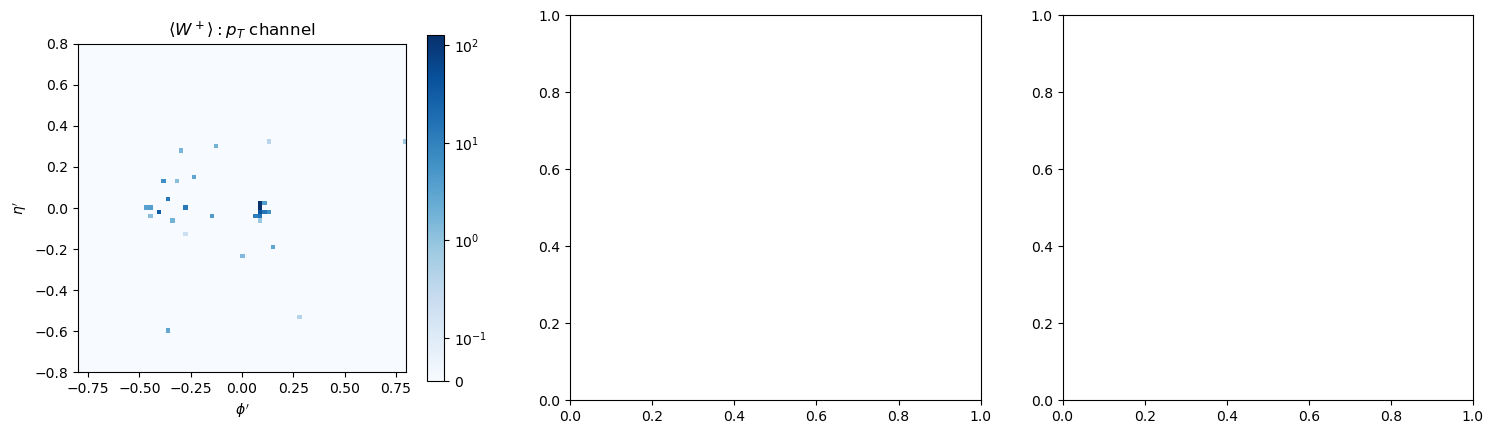

In [19]:
with open('/home/r10222035/boosted_V_ML_test/sample/samples_kappa0.15-10k-fish/VBF_H5pp_ww_jjjj.npy','rb') as f:
    hist = np.load(f, allow_pickle=True)[1]

    fig, ax = plt.subplots(1,3, figsize=(18,5))
    ## P_T distribution
    imag = ax[0].imshow(hist, extent=[-0.8, 0.8, -0.8, 0.8], norm=colors.SymLogNorm(linthresh=0.1, linscale=0.4,vmin=0), cmap='Blues')
    plt.colorbar(imag, ax=ax[0], shrink=0.9)
    ax[0].set_title(r'$\langle W^+\rangle: p_T$ channel')
    ax[0].set_xlabel(r'$\phi^\prime$')
    ax[0].set_ylabel(r'$\eta^\prime$')

    plt.show()

True


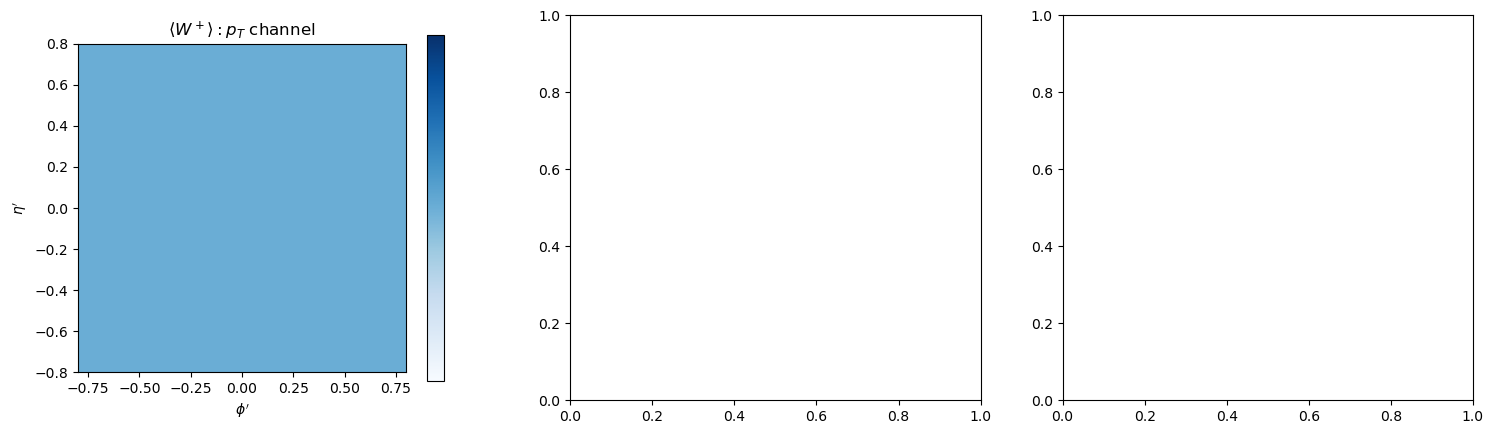

In [29]:
with open('/home/r10222035/boosted_V_ML_test/sample/samples_kappa0.15-10k/VBF_H5pp_ww_jjjj.npy','rb') as f:
    hist = np.load(f, allow_pickle=True)[1]
    fig, ax = plt.subplots(1,3, figsize=(18,5))
    ## P_T distribution
    imag = ax[0].imshow(hist, extent=[-0.8, 0.8, -0.8, 0.8], origin='lower', norm=colors.SymLogNorm(linthresh=0.1, linscale=0.4,vmin=0), cmap='Blues')
    plt.colorbar(imag, ax=ax[0], shrink=0.9)
    ax[0].set_title(r'$\langle W^+\rangle: p_T$ channel')
    ax[0].set_xlabel(r'$\phi^\prime$')
    ax[0].set_ylabel(r'$\eta^\prime$')

    plt.show()